In [1]:
# Core Libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, classification_report

# Misc
import kagglehub

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# Download the V3 dataset
data_dir = kagglehub.dataset_download("bharathry/glaucoma-dataset-for-ai-diagnosis-v3")
print("Downloaded at:", data_dir)

# Check the structure of the downloaded dataset
print("Root directory contents:", os.listdir(data_dir))

# Look for CSV file and images folder
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
image_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

print(f"CSV files found: {csv_files}")
print(f"Folders found: {image_folders}")

# Load the CSV file (assuming it contains labels)
if csv_files:
    csv_path = os.path.join(data_dir, csv_files[0])
    df = pd.read_csv(csv_path)
    print(f"\nLoaded CSV: {csv_files[0]} with {len(df)} rows")
    print(f"CSV columns: {list(df.columns)}")
    print(f"First few rows:")
    print(df.head())

    # Clean column names and labels
    df.columns = df.columns.str.strip()

    # Find the label column - specifically look for glaucoma_binary
    label_column = None
    if 'glaucoma_binary' in df.columns:
        label_column = 'glaucoma_binary'
        print(f"\nUsing '{label_column}' as label column")
        print(f"Unique labels in {label_column}: {df[label_column].unique()}")

        # Clean the label column and map to 0/1
        df[label_column] = pd.to_numeric(df[label_column], errors='coerce')  # Convert to numeric, NaN for invalid
        df = df.dropna(subset=[label_column])  # Remove rows with NaN labels
        df['label'] = df[label_column].astype(int)  # Convert to integer (0 or 1)

        print(f"After cleaning - unique labels: {df['label'].unique()}")
        print(f"After filtering: {len(df)} rows")
    else:
        # Fallback: look for other potential label columns
        for col in df.columns:
            if any(val in str(df[col].unique()) for val in ['GON+', 'GON-', 'glaucoma', 'normal']):
                label_column = col
                break

        if label_column:
            print(f"\nUsing '{label_column}' as label column")
            df[label_column] = df[label_column].str.strip().str.upper()
            print(f"Unique labels: {df[label_column].unique()}")

            # Map labels to 0/1
            if 'GON+' in df[label_column].unique():
                label_map = {"GON+": 1, "GON-": 0}
            else:
                # Handle other possible label formats
                unique_labels = df[label_column].unique()
                label_map = {unique_labels[0]: 0, unique_labels[1]: 1}

            df = df[df[label_column].isin(label_map.keys())]
            df['label'] = df[label_column].map(label_map)
            print(f"Label mapping: {label_map}")
            print(f"After filtering: {len(df)} rows")
        else:
            print("Warning: Could not identify label column automatically")
            print(f"Available columns: {list(df.columns)}")
            # Exit early if no label column found
            df = pd.DataFrame()

# Find images folder
images_folder = None
for folder in image_folders:
    folder_path = os.path.join(data_dir, folder)
    files_in_folder = os.listdir(folder_path)
    image_files = [f for f in files_in_folder if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if len(image_files) > 1000:  # Assume this is the main images folder
        images_folder = folder_path
        print(f"\nFound images folder: {folder} with {len(image_files)} images")
        break

if images_folder is None:
    print("Warning: Could not find images folder, checking root directory...")
    root_image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if root_image_files:
        images_folder = data_dir
        print(f"Found {len(root_image_files)} images in root directory")

# Create image-label pairs
image_label_list = []
missing_files = []

if not df.empty and images_folder:
    # Get image name column (usually first column or contains 'image', 'file', 'name')
    image_column = df.columns[0]  # Default to first column
    for col in df.columns:
        if any(keyword in col.lower() for keyword in ['image', 'file', 'name']):
            image_column = col
            break

    print(f"Using '{image_column}' as image filename column")

    for idx, row in df.iterrows():
        img_filename = str(row[image_column]).strip()
        label = row['label']

        # Try different possible image paths
        possible_paths = [
            os.path.join(images_folder, img_filename),
            os.path.join(images_folder, img_filename + '.jpg'),
            os.path.join(images_folder, img_filename + '.png'),
            os.path.join(images_folder, img_filename + '.jpeg')
        ]

        img_path = None
        for path in possible_paths:
            if os.path.exists(path):
                img_path = path
                break

        if img_path and not pd.isna(label):  # Only add if both image and label are valid
            image_label_list.append((img_path, int(label)))
        else:
            if not img_path:
                missing_files.append(img_filename)

print(f"\nDATASET SUMMARY:")
print(f"Total labeled images found: {len(image_label_list)}")
print(f"Missing files: {len(missing_files)}")
if len(missing_files) > 0 and len(missing_files) <= 10:
    print(f"Missing files: {missing_files}")
elif len(missing_files) > 10:
    print(f"First 10 missing files: {missing_files[:10]}")

# Count by class
if len(image_label_list) > 0:
    labels = [label for _, label in image_label_list]
    unique_labels, counts = np.unique(labels, return_counts=True)
    for label, count in zip(unique_labels, counts):
        class_name = "Normal" if label == 0 else "Glaucoma"
        print(f"{class_name} (label {label}): {count} images")
else:
    print("Error: No valid image-label pairs found!")

# Stratified splits: 80% train, 10% val, 10% test (standard ML proportions)
if len(image_label_list) > 0:
    # First split: separate test set (10% of total)
    train_val_idx, test_idx = train_test_split(
        range(len(image_label_list)),
        test_size=0.1,  # 10% for test
        stratify=[label for _, label in image_label_list],
        random_state=42
    )

    # Second split: separate train and val from remaining data (80% train, 10% val)
    # From the remaining 90%, we want 80/90 ≈ 0.889 for train and 10/90 ≈ 0.111 for val
    train_idx, val_idx = train_test_split(
        train_val_idx,
        test_size=0.111,  # This gives us ~10% of total for validation
        stratify=[image_label_list[i][1] for i in train_val_idx],
        random_state=42
    )

    train_split = [image_label_list[i] for i in train_idx]
    val_split = [image_label_list[i] for i in val_idx]
    test_split = [image_label_list[i] for i in test_idx]

    print(f"\nSPLIT SUMMARY (80% Train / 10% Val / 10% Test):")
    print(f"Train samples: {len(train_split)} ({len(train_split)/len(image_label_list)*100:.1f}%)")
    print(f"Val samples:   {len(val_split)} ({len(val_split)/len(image_label_list)*100:.1f}%)")
    print(f"Test samples:  {len(test_split)} ({len(test_split)/len(image_label_list)*100:.1f}%)")
    print(f"Total:         {len(train_split) + len(val_split) + len(test_split)}")

    # Check class distribution in each split
    train_labels = [label for _, label in train_split]
    val_labels = [label for _, label in val_split]
    test_labels = [label for _, label in test_split]

    print(f"\nCLASS DISTRIBUTION BY SPLIT:")
    for split_name, split_labels in [("Train", train_labels), ("Val", val_labels), ("Test", test_labels)]:
        unique, counts = np.unique(split_labels, return_counts=True)
        print(f"{split_name:>5}: ", end="")
        for label, count in zip(unique, counts):
            class_name = "Normal" if label == 0 else "Glaucoma"
            percentage = count / len(split_labels) * 100
            print(f"{class_name}: {count} ({percentage:.1f}%)  ", end="")
        print()

    # Save split information to CSV files
    train_df = pd.DataFrame(train_split, columns=['image_path', 'label'])
    val_df = pd.DataFrame(val_split, columns=['image_path', 'label'])
    test_df = pd.DataFrame(test_split, columns=['image_path', 'label'])

    # Save to CSV files
    train_df.to_csv('train_split.csv', index=False)
    val_df.to_csv('val_split.csv', index=False)
    test_df.to_csv('test_split.csv', index=False)

    print(f"\nSAVED SPLITS:")
    print(f"train_split.csv: {len(train_df)} images")
    print(f"val_split.csv: {len(val_df)} images")
    print(f"test_split.csv: {len(test_df)} images")
else:
    print("Error: No valid image-label pairs found. Please check the dataset structure.")

100%|██████████| 2.84G/2.84G [00:34<00:00, 87.9MB/s]

Extracting files...


Downloaded at: /root/.cache/kagglehub/datasets/bharathry/glaucoma-dataset-for-ai-diagnosis-v3/versions/1
Root directory contents: ['full_fundus_labels_binary.csv', 'full-fundus']
CSV files found: ['full_fundus_labels_binary.csv']
Folders found: ['full-fundus']

Loaded CSV: full_fundus_labels_binary.csv with 12398 rows
CSV columns: ['names', 'fundus', 'glaucoma_binary']
First few rows:
                     names                                    fundus  \
0  OIA-ODIR-TEST-OFFLINE-1  /full-fundus/OIA-ODIR-TEST-OFFLINE-1.png   
1  OIA-ODIR-TEST-OFFLINE-2  /full-fundus/OIA-ODIR-TEST-OFFLINE-2.png   
2  OIA-ODIR-TEST-OFFLINE-4  /full-fundus/OIA-ODIR-TEST-OFFLINE-4.png   
3  OIA-ODIR-TEST-OFFLINE-5  /full-fundus/OIA-ODIR-TEST-OFFLINE-5.png   
4  OIA-ODIR-TEST-OFFLINE-6  /full-fundus/OIA-ODIR-TEST-OFFLINE-6.png   

   glaucoma_binary  
0                0  
1                0  
2                0  
3                0  
4                0  

Using 'glaucoma_binary' as label column
Unique label

In [3]:
# Custom dataset class for EfficientNetV2
class GlaucomaDataset(Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path, label = self.image_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# EfficientNetV2 optimized parameters
IMG_SIZE = 288  # EfficientNetV2 performs better with larger input sizes
BATCH_SIZE = 16  # Smaller batch size for larger images and more complex model

# Enhanced data augmentation for better performance
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Validation/Test transform
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create datasets and loaders
train_dataset = GlaucomaDataset(train_split, transform=train_transform)
val_dataset = GlaucomaDataset(val_split, transform=val_transform)
test_dataset = GlaucomaDataset(test_split, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Data loaders created:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Data loaders created:
Train batches: 620
Val batches: 78
Test batches: 78


In [4]:
# Load EfficientNetV2 model with best configuration for performance
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

# Load pre-trained EfficientNetV2-S (Small variant for better speed/accuracy balance)
weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights)

# Modify the classifier for binary classification
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.3),
    nn.Linear(512, 2)
)

# Move model to device
model = model.to(device)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model loaded on: {device}")

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 187MB/s]


Total parameters: 20,834,386
Trainable parameters: 20,834,386
Model loaded on: cuda


In [5]:
# FASTER Training Configuration - Optimized for Speed
# This version will complete much faster while maintaining good performance

import time

# Optimized training parameters for faster execution
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Higher learning rate

EPOCHS = 20  # Reduced from 100
PATIENCE = 5  # Reduced patience for faster stopping

# Tracking variables
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
all_val_preds_by_epoch = []
all_val_labels_by_epoch = []

best_val_loss = float("inf")
best_weights = None
early_stop_counter = 0

print("FAST TRAINING MODE - Optimized for Speed!")
print(f"Training for maximum {EPOCHS} epochs with early stopping patience of {PATIENCE}")
print(f"Using higher learning rate (1e-3) for faster convergence")
print("="*60)

start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start = time.time()

    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    print(f"\nEpoch {epoch+1}/{EPOCHS} - Training...")

    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Print progress every 100 batches
        if batch_idx % 100 == 0:
            current_acc = 100 * correct / total if total > 0 else 0
            print(f"  Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f} | Acc: {current_acc:.2f}%")

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    print(f"Epoch {epoch+1}/{EPOCHS} - Validating...")
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    epoch_val_preds, epoch_val_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            epoch_val_preds.extend(preds.cpu().numpy())
            epoch_val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    all_val_preds_by_epoch.append(epoch_val_preds)
    all_val_labels_by_epoch.append(epoch_val_labels)

    epoch_time = time.time() - epoch_start
    total_time = time.time() - start_time

    print(f"\nEPOCH {epoch+1} COMPLETED:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"   Epoch Time: {epoch_time:.1f}s | Total Time: {total_time:.1f}s")

    # Save best model and early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = model.state_dict().copy()
        early_stop_counter = 0
        print(f"   NEW BEST MODEL! Val Loss improved to {val_loss:.4f}")
    else:
        early_stop_counter += 1
        print(f"   No improvement. Early stop counter: {early_stop_counter}/{PATIENCE}")
        if early_stop_counter >= PATIENCE:
            print(f"\nEARLY STOPPING triggered after {epoch+1} epochs")
            break

total_training_time = time.time() - start_time

# Load best weights and save model
print(f"\nTRAINING COMPLETED!")
print(f"Total training time: {total_training_time:.1f} seconds ({total_training_time/60:.1f} minutes)")
print(f"Best validation loss: {best_val_loss:.4f}")

if best_weights is not None:
    model.load_state_dict(best_weights)
    torch.save(best_weights, "best_glaucoma_model.pth")
    print("Best model weights saved to 'best_glaucoma_model.pth'")
else:
    print("No best weights found - using final model state")
    torch.save(model.state_dict(), "best_glaucoma_model.pth")

FAST TRAINING MODE - Optimized for Speed!
Training for maximum 20 epochs with early stopping patience of 5
Using higher learning rate (1e-3) for faster convergence

Epoch 1/20 - Training...


Training Epoch 1:   0%|          | 1/620 [00:02<28:53,  2.80s/it]

  Batch 0/620 | Loss: 0.7006 | Acc: 62.50%


Training Epoch 1:  16%|█▋        | 101/620 [00:35<03:06,  2.79it/s]

  Batch 100/620 | Loss: 0.6773 | Acc: 67.20%


Training Epoch 1:  32%|███▏      | 201/620 [01:07<02:05,  3.34it/s]

  Batch 200/620 | Loss: 0.4113 | Acc: 69.40%


Training Epoch 1:  49%|████▊     | 301/620 [01:39<02:02,  2.61it/s]

  Batch 300/620 | Loss: 0.6291 | Acc: 69.64%


Training Epoch 1:  65%|██████▍   | 401/620 [02:12<01:07,  3.25it/s]

  Batch 400/620 | Loss: 0.5100 | Acc: 69.90%


Training Epoch 1:  81%|████████  | 501/620 [02:44<00:46,  2.58it/s]

  Batch 500/620 | Loss: 0.5569 | Acc: 71.02%


Training Epoch 1:  97%|█████████▋| 601/620 [03:16<00:05,  3.28it/s]

  Batch 600/620 | Loss: 0.3272 | Acc: 71.37%


Training Epoch 1: 100%|██████████| 620/620 [03:23<00:00,  3.05it/s]


Epoch 1/20 - Validating...


Validation Epoch 1: 100%|██████████| 78/78 [00:12<00:00,  6.42it/s]



EPOCH 1 COMPLETED:
   Train Loss: 0.5802 | Train Acc: 71.55%
   Val Loss:   0.4861 | Val Acc:   78.69%
   Epoch Time: 215.4s | Total Time: 215.4s
   NEW BEST MODEL! Val Loss improved to 0.4861

Epoch 2/20 - Training...


Training Epoch 2:   0%|          | 1/620 [00:00<09:19,  1.11it/s]

  Batch 0/620 | Loss: 0.5157 | Acc: 75.00%


Training Epoch 2:  16%|█▋        | 101/620 [00:33<02:36,  3.31it/s]

  Batch 100/620 | Loss: 0.5215 | Acc: 77.35%


Training Epoch 2:  32%|███▏      | 201/620 [01:06<02:12,  3.17it/s]

  Batch 200/620 | Loss: 0.4246 | Acc: 77.46%


Training Epoch 2:  49%|████▊     | 301/620 [01:38<01:35,  3.35it/s]

  Batch 300/620 | Loss: 0.9021 | Acc: 77.74%


Training Epoch 2:  65%|██████▍   | 401/620 [02:10<01:08,  3.20it/s]

  Batch 400/620 | Loss: 0.4204 | Acc: 77.68%


Training Epoch 2:  81%|████████  | 501/620 [02:43<00:36,  3.30it/s]

  Batch 500/620 | Loss: 0.5604 | Acc: 77.57%


Training Epoch 2:  97%|█████████▋| 601/620 [03:16<00:06,  2.86it/s]

  Batch 600/620 | Loss: 0.4125 | Acc: 77.97%


Training Epoch 2: 100%|██████████| 620/620 [03:21<00:00,  3.07it/s]


Epoch 2/20 - Validating...


Validation Epoch 2: 100%|██████████| 78/78 [00:12<00:00,  6.41it/s]



EPOCH 2 COMPLETED:
   Train Loss: 0.4912 | Train Acc: 78.03%
   Val Loss:   0.4399 | Val Acc:   79.66%
   Epoch Time: 214.1s | Total Time: 429.5s
   NEW BEST MODEL! Val Loss improved to 0.4399

Epoch 3/20 - Training...


Training Epoch 3:   0%|          | 1/620 [00:00<08:26,  1.22it/s]

  Batch 0/620 | Loss: 0.5125 | Acc: 81.25%


Training Epoch 3:  16%|█▋        | 101/620 [00:33<02:35,  3.34it/s]

  Batch 100/620 | Loss: 0.4348 | Acc: 79.58%


Training Epoch 3:  32%|███▏      | 201/620 [01:06<02:31,  2.77it/s]

  Batch 200/620 | Loss: 0.9958 | Acc: 78.58%


Training Epoch 3:  49%|████▊     | 301/620 [01:38<01:36,  3.31it/s]

  Batch 300/620 | Loss: 0.2853 | Acc: 79.36%


Training Epoch 3:  65%|██████▍   | 401/620 [02:11<01:22,  2.66it/s]

  Batch 400/620 | Loss: 0.4574 | Acc: 79.66%


Training Epoch 3:  81%|████████  | 501/620 [02:43<00:36,  3.23it/s]

  Batch 500/620 | Loss: 0.3791 | Acc: 79.59%


Training Epoch 3:  97%|█████████▋| 601/620 [03:16<00:07,  2.43it/s]

  Batch 600/620 | Loss: 0.4656 | Acc: 79.59%


Training Epoch 3: 100%|██████████| 620/620 [03:22<00:00,  3.06it/s]


Epoch 3/20 - Validating...


Validation Epoch 3: 100%|██████████| 78/78 [00:12<00:00,  6.43it/s]



EPOCH 3 COMPLETED:
   Train Loss: 0.4626 | Train Acc: 79.72%
   Val Loss:   0.4971 | Val Acc:   80.31%
   Epoch Time: 214.6s | Total Time: 644.1s
   No improvement. Early stop counter: 1/5

Epoch 4/20 - Training...


Training Epoch 4:   0%|          | 1/620 [00:00<08:31,  1.21it/s]

  Batch 0/620 | Loss: 0.2695 | Acc: 87.50%


Training Epoch 4:  16%|█▋        | 101/620 [00:36<02:43,  3.17it/s]

  Batch 100/620 | Loss: 0.3454 | Acc: 79.83%


Training Epoch 4:  32%|███▏      | 201/620 [01:08<02:07,  3.28it/s]

  Batch 200/620 | Loss: 0.2974 | Acc: 80.29%


Training Epoch 4:  49%|████▊     | 301/620 [01:40<01:41,  3.14it/s]

  Batch 300/620 | Loss: 0.5263 | Acc: 80.38%


Training Epoch 4:  65%|██████▍   | 401/620 [02:12<01:09,  3.14it/s]

  Batch 400/620 | Loss: 0.5817 | Acc: 80.56%


Training Epoch 4:  81%|████████  | 501/620 [02:45<00:36,  3.30it/s]

  Batch 500/620 | Loss: 0.2513 | Acc: 81.04%


Training Epoch 4:  97%|█████████▋| 601/620 [03:18<00:07,  2.65it/s]

  Batch 600/620 | Loss: 0.4948 | Acc: 81.14%


Training Epoch 4: 100%|██████████| 620/620 [03:24<00:00,  3.03it/s]


Epoch 4/20 - Validating...


Validation Epoch 4: 100%|██████████| 78/78 [00:12<00:00,  6.34it/s]



EPOCH 4 COMPLETED:
   Train Loss: 0.4422 | Train Acc: 81.07%
   Val Loss:   0.3917 | Val Acc:   82.65%
   Epoch Time: 216.9s | Total Time: 861.0s
   NEW BEST MODEL! Val Loss improved to 0.3917

Epoch 5/20 - Training...


Training Epoch 5:   0%|          | 1/620 [00:00<08:26,  1.22it/s]

  Batch 0/620 | Loss: 0.6598 | Acc: 62.50%


Training Epoch 5:  16%|█▋        | 101/620 [00:33<03:29,  2.48it/s]

  Batch 100/620 | Loss: 0.2666 | Acc: 80.75%


Training Epoch 5:  32%|███▏      | 201/620 [01:06<02:09,  3.24it/s]

  Batch 200/620 | Loss: 0.4663 | Acc: 81.06%


Training Epoch 5:  49%|████▊     | 301/620 [01:39<01:51,  2.87it/s]

  Batch 300/620 | Loss: 0.3332 | Acc: 81.81%


Training Epoch 5:  65%|██████▍   | 401/620 [02:11<01:05,  3.34it/s]

  Batch 400/620 | Loss: 0.4357 | Acc: 81.86%


Training Epoch 5:  81%|████████  | 501/620 [02:44<00:36,  3.22it/s]

  Batch 500/620 | Loss: 0.4115 | Acc: 81.80%


Training Epoch 5:  97%|█████████▋| 601/620 [03:16<00:05,  3.30it/s]

  Batch 600/620 | Loss: 0.3764 | Acc: 81.69%


Training Epoch 5: 100%|██████████| 620/620 [03:22<00:00,  3.06it/s]


Epoch 5/20 - Validating...


Validation Epoch 5: 100%|██████████| 78/78 [00:12<00:00,  6.33it/s]



EPOCH 5 COMPLETED:
   Train Loss: 0.4246 | Train Acc: 81.80%
   Val Loss:   0.4537 | Val Acc:   80.39%
   Epoch Time: 215.2s | Total Time: 1076.2s
   No improvement. Early stop counter: 1/5

Epoch 6/20 - Training...


Training Epoch 6:   0%|          | 1/620 [00:00<08:59,  1.15it/s]

  Batch 0/620 | Loss: 0.4670 | Acc: 81.25%


Training Epoch 6:  16%|█▋        | 101/620 [00:32<02:43,  3.17it/s]

  Batch 100/620 | Loss: 0.3776 | Acc: 80.94%


Training Epoch 6:  32%|███▏      | 201/620 [01:06<02:07,  3.28it/s]

  Batch 200/620 | Loss: 0.2081 | Acc: 81.03%


Training Epoch 6:  49%|████▊     | 301/620 [01:38<01:35,  3.35it/s]

  Batch 300/620 | Loss: 0.4478 | Acc: 81.27%


Training Epoch 6:  65%|██████▍   | 401/620 [02:10<01:07,  3.24it/s]

  Batch 400/620 | Loss: 0.3184 | Acc: 81.58%


Training Epoch 6:  81%|████████  | 501/620 [02:42<00:38,  3.09it/s]

  Batch 500/620 | Loss: 0.3570 | Acc: 81.94%


Training Epoch 6:  97%|█████████▋| 601/620 [03:14<00:05,  3.30it/s]

  Batch 600/620 | Loss: 0.3800 | Acc: 81.86%


Training Epoch 6: 100%|██████████| 620/620 [03:20<00:00,  3.09it/s]


Epoch 6/20 - Validating...


Validation Epoch 6: 100%|██████████| 78/78 [00:12<00:00,  6.42it/s]



EPOCH 6 COMPLETED:
   Train Loss: 0.4272 | Train Acc: 81.78%
   Val Loss:   0.3705 | Val Acc:   82.16%
   Epoch Time: 212.9s | Total Time: 1289.2s
   NEW BEST MODEL! Val Loss improved to 0.3705

Epoch 7/20 - Training...


Training Epoch 7:   0%|          | 1/620 [00:00<09:43,  1.06it/s]

  Batch 0/620 | Loss: 0.5132 | Acc: 75.00%


Training Epoch 7:  16%|█▋        | 101/620 [00:34<02:36,  3.31it/s]

  Batch 100/620 | Loss: 0.2748 | Acc: 82.74%


Training Epoch 7:  32%|███▏      | 201/620 [01:06<02:46,  2.52it/s]

  Batch 200/620 | Loss: 0.4370 | Acc: 82.34%


Training Epoch 7:  49%|████▊     | 301/620 [01:39<01:36,  3.30it/s]

  Batch 300/620 | Loss: 0.4878 | Acc: 82.50%


Training Epoch 7:  65%|██████▍   | 401/620 [02:11<01:17,  2.83it/s]

  Batch 400/620 | Loss: 0.3893 | Acc: 82.50%


Training Epoch 7:  81%|████████  | 501/620 [02:43<00:35,  3.34it/s]

  Batch 500/620 | Loss: 0.3837 | Acc: 82.39%


Training Epoch 7:  97%|█████████▋| 601/620 [03:17<00:06,  3.08it/s]

  Batch 600/620 | Loss: 0.2639 | Acc: 82.56%


Training Epoch 7: 100%|██████████| 620/620 [03:23<00:00,  3.05it/s]


Epoch 7/20 - Validating...


Validation Epoch 7: 100%|██████████| 78/78 [00:12<00:00,  6.43it/s]



EPOCH 7 COMPLETED:
   Train Loss: 0.4071 | Train Acc: 82.55%
   Val Loss:   0.3794 | Val Acc:   83.62%
   Epoch Time: 215.6s | Total Time: 1504.8s
   No improvement. Early stop counter: 1/5

Epoch 8/20 - Training...


Training Epoch 8:   0%|          | 1/620 [00:00<08:36,  1.20it/s]

  Batch 0/620 | Loss: 0.3670 | Acc: 81.25%


Training Epoch 8:  16%|█▋        | 101/620 [00:33<02:36,  3.32it/s]

  Batch 100/620 | Loss: 0.3227 | Acc: 82.67%


Training Epoch 8:  32%|███▏      | 201/620 [01:06<02:06,  3.31it/s]

  Batch 200/620 | Loss: 0.3930 | Acc: 82.56%


Training Epoch 8:  49%|████▊     | 301/620 [01:38<01:39,  3.21it/s]

  Batch 300/620 | Loss: 0.2039 | Acc: 83.10%


Training Epoch 8:  65%|██████▍   | 401/620 [02:11<01:26,  2.52it/s]

  Batch 400/620 | Loss: 0.2232 | Acc: 83.18%


Training Epoch 8:  81%|████████  | 501/620 [02:44<00:36,  3.29it/s]

  Batch 500/620 | Loss: 0.2428 | Acc: 82.90%


Training Epoch 8:  97%|█████████▋| 601/620 [03:16<00:07,  2.50it/s]

  Batch 600/620 | Loss: 0.4240 | Acc: 83.07%


Training Epoch 8: 100%|██████████| 620/620 [03:22<00:00,  3.06it/s]


Epoch 8/20 - Validating...


Validation Epoch 8: 100%|██████████| 78/78 [00:12<00:00,  6.33it/s]



EPOCH 8 COMPLETED:
   Train Loss: 0.4029 | Train Acc: 83.06%
   Val Loss:   0.4036 | Val Acc:   82.24%
   Epoch Time: 215.1s | Total Time: 1719.8s
   No improvement. Early stop counter: 2/5

Epoch 9/20 - Training...


Training Epoch 9:   0%|          | 1/620 [00:00<08:48,  1.17it/s]

  Batch 0/620 | Loss: 0.4431 | Acc: 81.25%


Training Epoch 9:  16%|█▋        | 101/620 [00:33<03:15,  2.66it/s]

  Batch 100/620 | Loss: 0.3573 | Acc: 83.04%


Training Epoch 9:  32%|███▏      | 201/620 [01:05<02:10,  3.21it/s]

  Batch 200/620 | Loss: 0.2609 | Acc: 83.08%


Training Epoch 9:  49%|████▊     | 301/620 [01:38<01:55,  2.77it/s]

  Batch 300/620 | Loss: 0.3910 | Acc: 82.85%


Training Epoch 9:  65%|██████▍   | 401/620 [02:10<01:06,  3.28it/s]

  Batch 400/620 | Loss: 0.1051 | Acc: 82.62%


Training Epoch 9:  81%|████████  | 501/620 [02:43<00:38,  3.08it/s]

  Batch 500/620 | Loss: 0.3119 | Acc: 82.93%


Training Epoch 9:  97%|█████████▋| 601/620 [03:15<00:05,  3.35it/s]

  Batch 600/620 | Loss: 0.3746 | Acc: 83.04%


Training Epoch 9: 100%|██████████| 620/620 [03:22<00:00,  3.06it/s]


Epoch 9/20 - Validating...


Validation Epoch 9: 100%|██████████| 78/78 [00:12<00:00,  6.42it/s]



EPOCH 9 COMPLETED:
   Train Loss: 0.3941 | Train Acc: 82.96%
   Val Loss:   0.3950 | Val Acc:   82.16%
   Epoch Time: 214.5s | Total Time: 1934.3s
   No improvement. Early stop counter: 3/5

Epoch 10/20 - Training...


Training Epoch 10:   0%|          | 1/620 [00:00<08:28,  1.22it/s]

  Batch 0/620 | Loss: 0.3738 | Acc: 87.50%


Training Epoch 10:  16%|█▋        | 101/620 [00:32<02:40,  3.24it/s]

  Batch 100/620 | Loss: 0.2066 | Acc: 83.48%


Training Epoch 10:  32%|███▏      | 201/620 [01:05<02:09,  3.22it/s]

  Batch 200/620 | Loss: 0.3904 | Acc: 82.71%


Training Epoch 10:  49%|████▊     | 301/620 [01:37<01:37,  3.28it/s]

  Batch 300/620 | Loss: 0.3339 | Acc: 83.06%


Training Epoch 10:  65%|██████▍   | 401/620 [02:09<01:07,  3.23it/s]

  Batch 400/620 | Loss: 0.3648 | Acc: 83.28%


Training Epoch 10:  81%|████████  | 501/620 [02:41<00:36,  3.30it/s]

  Batch 500/620 | Loss: 0.3417 | Acc: 83.40%


Training Epoch 10:  97%|█████████▋| 601/620 [03:13<00:05,  3.26it/s]

  Batch 600/620 | Loss: 0.5505 | Acc: 83.18%


Training Epoch 10: 100%|██████████| 620/620 [03:19<00:00,  3.11it/s]


Epoch 10/20 - Validating...


Validation Epoch 10: 100%|██████████| 78/78 [00:12<00:00,  6.43it/s]



EPOCH 10 COMPLETED:
   Train Loss: 0.3958 | Train Acc: 83.18%
   Val Loss:   0.3582 | Val Acc:   84.26%
   Epoch Time: 211.6s | Total Time: 2145.9s
   NEW BEST MODEL! Val Loss improved to 0.3582

Epoch 11/20 - Training...


Training Epoch 11:   0%|          | 1/620 [00:00<08:32,  1.21it/s]

  Batch 0/620 | Loss: 0.3819 | Acc: 81.25%


Training Epoch 11:  16%|█▋        | 101/620 [00:33<02:37,  3.29it/s]

  Batch 100/620 | Loss: 0.3920 | Acc: 83.91%


Training Epoch 11:  32%|███▏      | 201/620 [01:05<02:08,  3.26it/s]

  Batch 200/620 | Loss: 0.6898 | Acc: 83.64%


Training Epoch 11:  49%|████▊     | 301/620 [01:37<01:37,  3.29it/s]

  Batch 300/620 | Loss: 0.3284 | Acc: 83.80%


Training Epoch 11:  65%|██████▍   | 401/620 [02:10<01:14,  2.92it/s]

  Batch 400/620 | Loss: 0.5533 | Acc: 83.93%


Training Epoch 11:  81%|████████  | 501/620 [02:42<00:36,  3.24it/s]

  Batch 500/620 | Loss: 0.4160 | Acc: 84.13%


Training Epoch 11:  97%|█████████▋| 601/620 [03:14<00:06,  2.84it/s]

  Batch 600/620 | Loss: 0.5441 | Acc: 83.91%


Training Epoch 11: 100%|██████████| 620/620 [03:20<00:00,  3.09it/s]


Epoch 11/20 - Validating...


Validation Epoch 11: 100%|██████████| 78/78 [00:12<00:00,  6.45it/s]



EPOCH 11 COMPLETED:
   Train Loss: 0.3851 | Train Acc: 83.94%
   Val Loss:   0.3789 | Val Acc:   84.50%
   Epoch Time: 213.0s | Total Time: 2358.8s
   No improvement. Early stop counter: 1/5

Epoch 12/20 - Training...


Training Epoch 12:   0%|          | 1/620 [00:00<08:30,  1.21it/s]

  Batch 0/620 | Loss: 0.5911 | Acc: 68.75%


Training Epoch 12:  16%|█▋        | 101/620 [00:33<02:53,  2.99it/s]

  Batch 100/620 | Loss: 0.5313 | Acc: 83.66%


Training Epoch 12:  32%|███▏      | 201/620 [01:05<02:13,  3.13it/s]

  Batch 200/620 | Loss: 0.3630 | Acc: 83.64%


Training Epoch 12:  49%|████▊     | 301/620 [01:38<01:58,  2.68it/s]

  Batch 300/620 | Loss: 0.3708 | Acc: 84.22%


Training Epoch 12:  65%|██████▍   | 401/620 [02:10<01:06,  3.30it/s]

  Batch 400/620 | Loss: 0.4115 | Acc: 84.46%


Training Epoch 12:  81%|████████  | 501/620 [02:42<00:40,  2.92it/s]

  Batch 500/620 | Loss: 0.1003 | Acc: 84.27%


Training Epoch 12:  97%|█████████▋| 601/620 [03:15<00:05,  3.26it/s]

  Batch 600/620 | Loss: 0.3982 | Acc: 84.04%


Training Epoch 12: 100%|██████████| 620/620 [03:21<00:00,  3.08it/s]


Epoch 12/20 - Validating...


Validation Epoch 12: 100%|██████████| 78/78 [00:12<00:00,  6.41it/s]



EPOCH 12 COMPLETED:
   Train Loss: 0.3752 | Train Acc: 84.07%
   Val Loss:   0.3664 | Val Acc:   84.42%
   Epoch Time: 213.8s | Total Time: 2572.6s
   No improvement. Early stop counter: 2/5

Epoch 13/20 - Training...


Training Epoch 13:   0%|          | 1/620 [00:00<08:29,  1.21it/s]

  Batch 0/620 | Loss: 0.3003 | Acc: 87.50%


Training Epoch 13:  16%|█▋        | 101/620 [00:32<02:36,  3.31it/s]

  Batch 100/620 | Loss: 0.2692 | Acc: 85.33%


Training Epoch 13:  32%|███▏      | 201/620 [01:05<02:11,  3.18it/s]

  Batch 200/620 | Loss: 0.2558 | Acc: 85.32%


Training Epoch 13:  49%|████▊     | 301/620 [01:37<01:37,  3.28it/s]

  Batch 300/620 | Loss: 0.4444 | Acc: 85.26%


Training Epoch 13:  65%|██████▍   | 401/620 [02:10<01:08,  3.18it/s]

  Batch 400/620 | Loss: 0.3123 | Acc: 84.66%


Training Epoch 13:  81%|████████  | 501/620 [02:43<00:36,  3.24it/s]

  Batch 500/620 | Loss: 0.3189 | Acc: 84.52%


Training Epoch 13:  97%|█████████▋| 601/620 [03:15<00:05,  3.24it/s]

  Batch 600/620 | Loss: 0.7692 | Acc: 84.72%


Training Epoch 13: 100%|██████████| 620/620 [03:21<00:00,  3.08it/s]


Epoch 13/20 - Validating...


Validation Epoch 13: 100%|██████████| 78/78 [00:12<00:00,  6.42it/s]



EPOCH 13 COMPLETED:
   Train Loss: 0.3702 | Train Acc: 84.73%
   Val Loss:   0.3569 | Val Acc:   84.10%
   Epoch Time: 213.8s | Total Time: 2786.4s
   NEW BEST MODEL! Val Loss improved to 0.3569

Epoch 14/20 - Training...


Training Epoch 14:   0%|          | 1/620 [00:01<11:25,  1.11s/it]

  Batch 0/620 | Loss: 0.7121 | Acc: 75.00%


Training Epoch 14:  16%|█▋        | 101/620 [00:34<02:39,  3.26it/s]

  Batch 100/620 | Loss: 0.3029 | Acc: 83.42%


Training Epoch 14:  32%|███▏      | 201/620 [01:06<02:27,  2.84it/s]

  Batch 200/620 | Loss: 0.6604 | Acc: 83.77%


Training Epoch 14:  49%|████▊     | 301/620 [01:39<01:37,  3.27it/s]

  Batch 300/620 | Loss: 0.2712 | Acc: 84.43%


Training Epoch 14:  65%|██████▍   | 401/620 [02:11<01:30,  2.42it/s]

  Batch 400/620 | Loss: 0.2760 | Acc: 84.37%


Training Epoch 14:  81%|████████  | 501/620 [02:43<00:36,  3.27it/s]

  Batch 500/620 | Loss: 0.3097 | Acc: 84.61%


Training Epoch 14:  97%|█████████▋| 601/620 [03:16<00:06,  2.96it/s]

  Batch 600/620 | Loss: 0.2702 | Acc: 84.69%


Training Epoch 14: 100%|██████████| 620/620 [03:22<00:00,  3.06it/s]


Epoch 14/20 - Validating...


Validation Epoch 14: 100%|██████████| 78/78 [00:12<00:00,  6.35it/s]



EPOCH 14 COMPLETED:
   Train Loss: 0.3636 | Train Acc: 84.59%
   Val Loss:   0.3818 | Val Acc:   83.21%
   Epoch Time: 214.9s | Total Time: 3001.3s
   No improvement. Early stop counter: 1/5

Epoch 15/20 - Training...


Training Epoch 15:   0%|          | 1/620 [00:00<08:16,  1.25it/s]

  Batch 0/620 | Loss: 0.5438 | Acc: 62.50%


Training Epoch 15:  16%|█▋        | 101/620 [00:33<02:50,  3.05it/s]

  Batch 100/620 | Loss: 0.2666 | Acc: 84.78%


Training Epoch 15:  32%|███▏      | 201/620 [01:05<02:06,  3.31it/s]

  Batch 200/620 | Loss: 0.2858 | Acc: 84.83%


Training Epoch 15:  49%|████▊     | 301/620 [01:37<01:56,  2.74it/s]

  Batch 300/620 | Loss: 0.3439 | Acc: 84.61%


Training Epoch 15:  65%|██████▍   | 401/620 [02:09<01:07,  3.23it/s]

  Batch 400/620 | Loss: 0.1876 | Acc: 85.02%


Training Epoch 15:  81%|████████  | 501/620 [02:42<00:42,  2.82it/s]

  Batch 500/620 | Loss: 0.3558 | Acc: 84.98%


Training Epoch 15:  97%|█████████▋| 601/620 [03:14<00:05,  3.27it/s]

  Batch 600/620 | Loss: 0.3393 | Acc: 85.08%


Training Epoch 15: 100%|██████████| 620/620 [03:20<00:00,  3.09it/s]


Epoch 15/20 - Validating...


Validation Epoch 15: 100%|██████████| 78/78 [00:12<00:00,  6.46it/s]



EPOCH 15 COMPLETED:
   Train Loss: 0.3561 | Train Acc: 85.11%
   Val Loss:   0.3679 | Val Acc:   84.50%
   Epoch Time: 212.9s | Total Time: 3214.2s
   No improvement. Early stop counter: 2/5

Epoch 16/20 - Training...


Training Epoch 16:   0%|          | 1/620 [00:00<08:26,  1.22it/s]

  Batch 0/620 | Loss: 0.2575 | Acc: 87.50%


Training Epoch 16:  16%|█▋        | 101/620 [00:32<02:39,  3.25it/s]

  Batch 100/620 | Loss: 0.6000 | Acc: 83.11%


Training Epoch 16:  32%|███▏      | 201/620 [01:05<02:17,  3.04it/s]

  Batch 200/620 | Loss: 0.4511 | Acc: 84.55%


Training Epoch 16:  49%|████▊     | 301/620 [01:37<01:37,  3.28it/s]

  Batch 300/620 | Loss: 0.0954 | Acc: 85.15%


Training Epoch 16:  65%|██████▍   | 401/620 [02:10<01:09,  3.15it/s]

  Batch 400/620 | Loss: 0.7059 | Acc: 85.08%


Training Epoch 16:  81%|████████  | 501/620 [02:42<00:36,  3.27it/s]

  Batch 500/620 | Loss: 0.4963 | Acc: 85.19%


Training Epoch 16:  97%|█████████▋| 601/620 [03:15<00:05,  3.20it/s]

  Batch 600/620 | Loss: 0.2045 | Acc: 85.26%


Training Epoch 16: 100%|██████████| 620/620 [03:20<00:00,  3.09it/s]


Epoch 16/20 - Validating...


Validation Epoch 16: 100%|██████████| 78/78 [00:12<00:00,  6.50it/s]



EPOCH 16 COMPLETED:
   Train Loss: 0.3531 | Train Acc: 85.33%
   Val Loss:   0.3525 | Val Acc:   83.86%
   Epoch Time: 212.8s | Total Time: 3427.0s
   NEW BEST MODEL! Val Loss improved to 0.3525

Epoch 17/20 - Training...


Training Epoch 17:   0%|          | 1/620 [00:00<08:25,  1.23it/s]

  Batch 0/620 | Loss: 0.3122 | Acc: 87.50%


Training Epoch 17:  16%|█▋        | 101/620 [00:33<02:47,  3.10it/s]

  Batch 100/620 | Loss: 0.1045 | Acc: 85.89%


Training Epoch 17:  32%|███▏      | 201/620 [01:05<02:07,  3.28it/s]

  Batch 200/620 | Loss: 0.2643 | Acc: 85.91%


Training Epoch 17:  49%|████▊     | 301/620 [01:38<01:39,  3.20it/s]

  Batch 300/620 | Loss: 0.5287 | Acc: 85.61%


Training Epoch 17:  65%|██████▍   | 401/620 [02:10<01:06,  3.29it/s]

  Batch 400/620 | Loss: 0.1466 | Acc: 85.75%


Training Epoch 17:  81%|████████  | 501/620 [02:42<00:37,  3.20it/s]

  Batch 500/620 | Loss: 0.4448 | Acc: 85.60%


Training Epoch 17:  97%|█████████▋| 601/620 [03:14<00:05,  3.29it/s]

  Batch 600/620 | Loss: 0.2542 | Acc: 85.37%


Training Epoch 17: 100%|██████████| 620/620 [03:20<00:00,  3.09it/s]


Epoch 17/20 - Validating...


Validation Epoch 17: 100%|██████████| 78/78 [00:12<00:00,  6.26it/s]



EPOCH 17 COMPLETED:
   Train Loss: 0.3452 | Train Acc: 85.31%
   Val Loss:   0.3567 | Val Acc:   85.15%
   Epoch Time: 213.4s | Total Time: 3640.5s
   No improvement. Early stop counter: 1/5

Epoch 18/20 - Training...


Training Epoch 18:   0%|          | 1/620 [00:00<08:39,  1.19it/s]

  Batch 0/620 | Loss: 0.3691 | Acc: 81.25%


Training Epoch 18:  16%|█▋        | 101/620 [00:32<02:46,  3.12it/s]

  Batch 100/620 | Loss: 0.2188 | Acc: 86.08%


Training Epoch 18:  32%|███▏      | 201/620 [01:05<02:11,  3.18it/s]

  Batch 200/620 | Loss: 0.2813 | Acc: 85.73%


Training Epoch 18:  49%|████▊     | 301/620 [01:37<01:51,  2.85it/s]

  Batch 300/620 | Loss: 0.1649 | Acc: 85.61%


Training Epoch 18:  65%|██████▍   | 401/620 [02:09<01:07,  3.26it/s]

  Batch 400/620 | Loss: 0.2239 | Acc: 85.43%


Training Epoch 18:  81%|████████  | 501/620 [02:41<00:36,  3.23it/s]

  Batch 500/620 | Loss: 0.1605 | Acc: 85.77%


Training Epoch 18:  97%|█████████▋| 601/620 [03:14<00:05,  3.29it/s]

  Batch 600/620 | Loss: 0.3460 | Acc: 85.53%


Training Epoch 18: 100%|██████████| 620/620 [03:20<00:00,  3.09it/s]


Epoch 18/20 - Validating...


Validation Epoch 18: 100%|██████████| 78/78 [00:11<00:00,  6.60it/s]



EPOCH 18 COMPLETED:
   Train Loss: 0.3451 | Train Acc: 85.52%
   Val Loss:   0.3565 | Val Acc:   84.18%
   Epoch Time: 212.2s | Total Time: 3852.7s
   No improvement. Early stop counter: 2/5

Epoch 19/20 - Training...


Training Epoch 19:   0%|          | 1/620 [00:01<11:16,  1.09s/it]

  Batch 0/620 | Loss: 0.2038 | Acc: 93.75%


Training Epoch 19:  16%|█▋        | 101/620 [00:34<02:40,  3.23it/s]

  Batch 100/620 | Loss: 0.2150 | Acc: 86.39%


Training Epoch 19:  32%|███▏      | 201/620 [01:06<02:52,  2.43it/s]

  Batch 200/620 | Loss: 0.6285 | Acc: 86.82%


Training Epoch 19:  49%|████▊     | 301/620 [01:39<01:39,  3.21it/s]

  Batch 300/620 | Loss: 0.2195 | Acc: 86.42%


Training Epoch 19:  65%|██████▍   | 401/620 [02:11<01:16,  2.86it/s]

  Batch 400/620 | Loss: 0.3647 | Acc: 85.96%


Training Epoch 19:  81%|████████  | 501/620 [02:44<00:36,  3.27it/s]

  Batch 500/620 | Loss: 0.2405 | Acc: 85.88%


Training Epoch 19:  97%|█████████▋| 601/620 [03:16<00:06,  3.12it/s]

  Batch 600/620 | Loss: 0.4268 | Acc: 85.92%


Training Epoch 19: 100%|██████████| 620/620 [03:23<00:00,  3.05it/s]


Epoch 19/20 - Validating...


Validation Epoch 19: 100%|██████████| 78/78 [00:12<00:00,  6.38it/s]



EPOCH 19 COMPLETED:
   Train Loss: 0.3419 | Train Acc: 85.93%
   Val Loss:   0.3367 | Val Acc:   85.07%
   Epoch Time: 215.3s | Total Time: 4067.9s
   NEW BEST MODEL! Val Loss improved to 0.3367

Epoch 20/20 - Training...


Training Epoch 20:   0%|          | 1/620 [00:00<08:41,  1.19it/s]

  Batch 0/620 | Loss: 0.3468 | Acc: 81.25%


Training Epoch 20:  16%|█▋        | 101/620 [00:33<02:40,  3.24it/s]

  Batch 100/620 | Loss: 0.2241 | Acc: 85.64%


Training Epoch 20:  32%|███▏      | 201/620 [01:05<02:08,  3.27it/s]

  Batch 200/620 | Loss: 0.4120 | Acc: 85.45%


Training Epoch 20:  49%|████▊     | 301/620 [01:38<01:42,  3.12it/s]

  Batch 300/620 | Loss: 0.3950 | Acc: 85.98%


Training Epoch 20:  65%|██████▍   | 401/620 [02:09<01:07,  3.25it/s]

  Batch 400/620 | Loss: 0.3197 | Acc: 85.58%


Training Epoch 20:  81%|████████  | 501/620 [02:42<00:36,  3.24it/s]

  Batch 500/620 | Loss: 0.2198 | Acc: 85.95%


Training Epoch 20:  97%|█████████▋| 601/620 [03:14<00:05,  3.31it/s]

  Batch 600/620 | Loss: 0.2168 | Acc: 85.85%


Training Epoch 20: 100%|██████████| 620/620 [03:20<00:00,  3.09it/s]


Epoch 20/20 - Validating...


Validation Epoch 20: 100%|██████████| 78/78 [00:12<00:00,  6.36it/s]



EPOCH 20 COMPLETED:
   Train Loss: 0.3429 | Train Acc: 85.85%
   Val Loss:   0.3689 | Val Acc:   85.55%
   Epoch Time: 212.7s | Total Time: 4280.7s
   No improvement. Early stop counter: 1/5

TRAINING COMPLETED!
Total training time: 4280.7 seconds (71.3 minutes)
Best validation loss: 0.3367
Best model weights saved to 'best_glaucoma_model.pth'


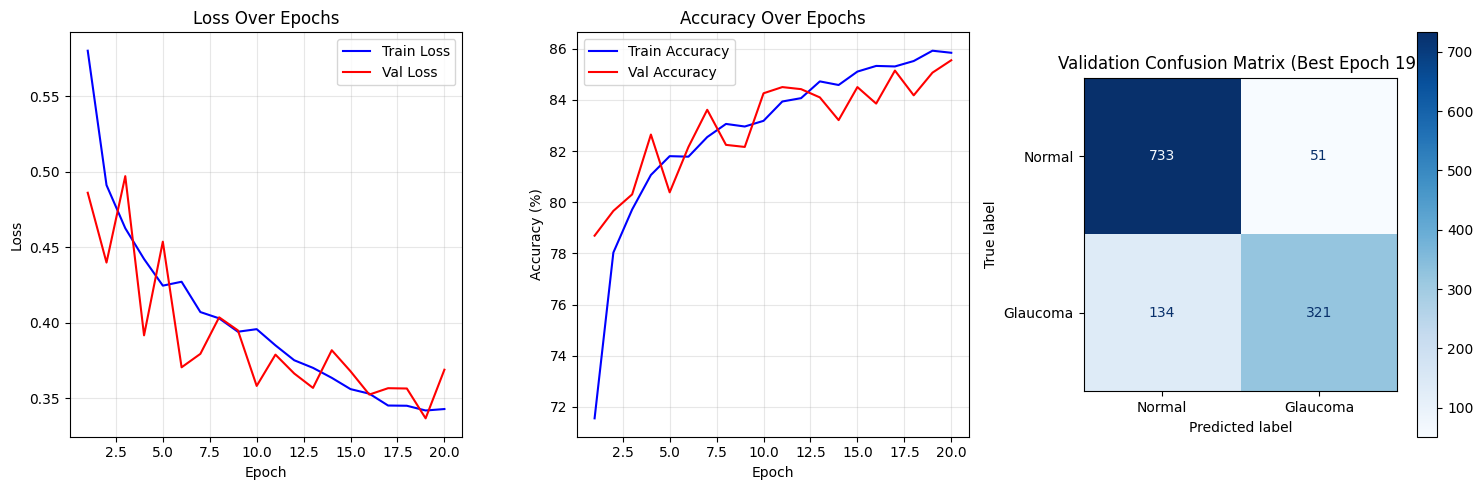


Training Summary:
Total epochs trained: 20
Best validation loss: 0.3367 (Epoch 19)
Best validation accuracy: 85.55% (Epoch 20)
Final training accuracy: 85.85%
Final validation accuracy: 85.55%


In [6]:
# Training Results Visualization
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label="Train Loss", color='blue')
plt.plot(epochs_range, val_losses, label="Val Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy", color='blue')
plt.plot(epochs_range, val_accuracies, label="Val Accuracy", color='red')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.grid(True, alpha=0.3)

# Confusion matrix from best epoch
plt.subplot(1, 3, 3)
if all_val_labels_by_epoch and all_val_preds_by_epoch:
    # Find the epoch with best validation loss
    best_epoch_idx = val_losses.index(min(val_losses))
    cm = confusion_matrix(all_val_labels_by_epoch[best_epoch_idx], all_val_preds_by_epoch[best_epoch_idx])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Glaucoma"])
    disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
    plt.title(f"Validation Confusion Matrix (Best Epoch {best_epoch_idx+1})")
else:
    plt.text(0.5, 0.5, 'No validation data available', ha='center', va='center')
    plt.title("Confusion Matrix")

plt.tight_layout()
plt.savefig("efficientnetv2_training_results.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTraining Summary:")
print(f"Total epochs trained: {len(train_losses)}")
print(f"Best validation loss: {min(val_losses):.4f} (Epoch {val_losses.index(min(val_losses))+1})")
print(f"Best validation accuracy: {max(val_accuracies):.2f}% (Epoch {val_accuracies.index(max(val_accuracies))+1})")
print(f"Final training accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final validation accuracy: {val_accuracies[-1]:.2f}%")

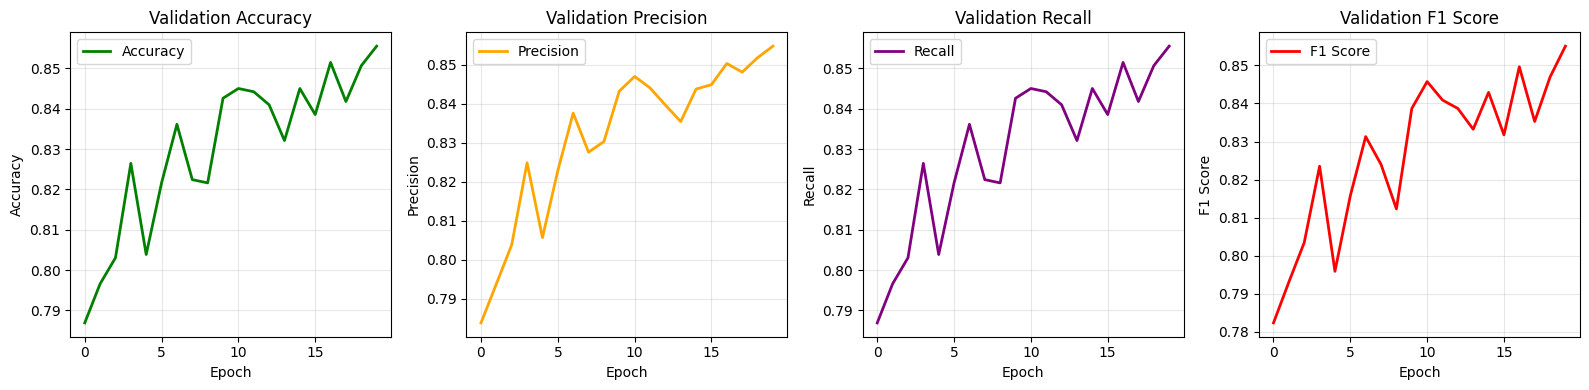


=== BEST VALIDATION METRICS ===
Best Accuracy: 0.8555 (Epoch 20)
Best Precision: 0.8548
Best Recall: 0.8555
Best F1-Score: 0.8551 (Epoch 20)


In [7]:
# Detailed Validation Metrics Analysis
val_metrics = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1_score": []
}

# Compute metrics per epoch
for preds, labels in zip(all_val_preds_by_epoch, all_val_labels_by_epoch):
    val_metrics["accuracy"].append(accuracy_score(labels, preds))
    val_metrics["precision"].append(precision_score(labels, preds, average='weighted', zero_division=0))
    val_metrics["recall"].append(recall_score(labels, preds, average='weighted', zero_division=0))
    val_metrics["f1_score"].append(f1_score(labels, preds, average='weighted', zero_division=0))

# Plot validation metrics evolution
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.plot(val_metrics["accuracy"], label="Accuracy", color='green', linewidth=2)
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(val_metrics["precision"], label="Precision", color='orange', linewidth=2)
plt.title("Validation Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(val_metrics["recall"], label="Recall", color='purple', linewidth=2)
plt.title("Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(val_metrics["f1_score"], label="F1 Score", color='red', linewidth=2)
plt.title("Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig("efficientnetv2_validation_metrics.png", dpi=300, bbox_inches='tight')
plt.show()

# Print best metrics
best_acc_epoch = np.argmax(val_metrics["accuracy"]) + 1
best_f1_epoch = np.argmax(val_metrics["f1_score"]) + 1

print(f"\n=== BEST VALIDATION METRICS ===")
print(f"Best Accuracy: {max(val_metrics['accuracy']):.4f} (Epoch {best_acc_epoch})")
print(f"Best Precision: {max(val_metrics['precision']):.4f}")
print(f"Best Recall: {max(val_metrics['recall']):.4f}")
print(f"Best F1-Score: {max(val_metrics['f1_score']):.4f} (Epoch {best_f1_epoch})")

COMPREHENSIVE TEST SET EVALUATION


Evaluating Test Set: 100%|██████████| 78/78 [00:12<00:00,  6.39it/s]



FINAL TEST SET RESULTS:
Test Accuracy:  0.8742 (87.42%)
Test Precision: 0.8743
Test Recall:    0.8742
Test F1-Score:  0.8743

PER-CLASS METRICS:
Normal:
  Precision: 0.9015
  Recall:    0.8992
  F1-Score:  0.9004
Glaucoma:
  Precision: 0.8275
  Recall:    0.8311
  F1-Score:  0.8293

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Normal       0.90      0.90      0.90       784
    Glaucoma       0.83      0.83      0.83       456

    accuracy                           0.87      1240
   macro avg       0.86      0.87      0.86      1240
weighted avg       0.87      0.87      0.87      1240



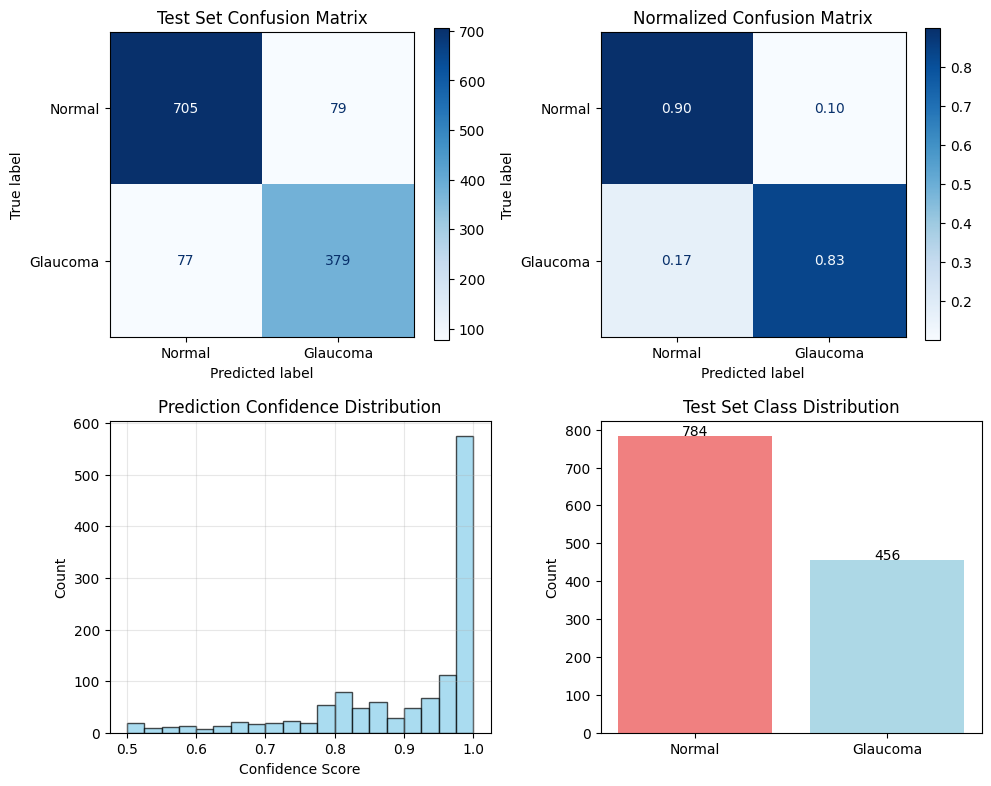

TypeError: Object of type int64 is not JSON serializable

In [8]:
# Comprehensive Test Set Evaluation
print("="*60)
print("COMPREHENSIVE TEST SET EVALUATION")
print("="*60)

# Ensure we're using the best model
model.eval()

# Test set evaluation
test_correct, test_total = 0, 0
test_preds, test_labels = [], []
test_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Get probabilities for more detailed analysis
        probs = torch.softmax(outputs, dim=1)
        test_probs.extend(probs.cpu().numpy())

        _, preds = outputs.max(1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total

# Calculate comprehensive test metrics
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')
test_f1 = f1_score(test_labels, test_preds, average='weighted')

# Per-class metrics
test_precision_per_class = precision_score(test_labels, test_preds, average=None)
test_recall_per_class = recall_score(test_labels, test_preds, average=None)
test_f1_per_class = f1_score(test_labels, test_preds, average=None)

print(f"\nFINAL TEST SET RESULTS:")
print(f"{'='*40}")
print(f"Test Accuracy:  {test_accuracy:.4f} ({test_acc:.2f}%)")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test F1-Score:  {test_f1:.4f}")

print(f"\nPER-CLASS METRICS:")
print(f"{'='*40}")
class_names = ["Normal", "Glaucoma"]
for i, class_name in enumerate(class_names):
    print(f"{class_name}:")
    print(f"  Precision: {test_precision_per_class[i]:.4f}")
    print(f"  Recall:    {test_recall_per_class[i]:.4f}")
    print(f"  F1-Score:  {test_f1_per_class[i]:.4f}")

print(f"\nDETAILED CLASSIFICATION REPORT:")
print(f"{'='*50}")
print(classification_report(test_labels, test_preds, target_names=class_names))

# Test confusion matrix with enhanced visualization
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
cm_test = confusion_matrix(test_labels, test_preds)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_names)
disp_test.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.title("Test Set Confusion Matrix")

# Normalized confusion matrix
plt.subplot(2, 2, 2)
cm_norm = confusion_matrix(test_labels, test_preds, normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
disp_norm.plot(cmap="Blues", values_format=".2f", ax=plt.gca())
plt.title("Normalized Confusion Matrix")

# Prediction confidence distribution
plt.subplot(2, 2, 3)
test_probs = np.array(test_probs)
confidence_scores = np.max(test_probs, axis=1)
plt.hist(confidence_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence Score")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)

# Class distribution in test set
plt.subplot(2, 2, 4)
unique, counts = np.unique(test_labels, return_counts=True)
plt.bar([class_names[i] for i in unique], counts, color=['lightcoral', 'lightblue'])
plt.title("Test Set Class Distribution")
plt.ylabel("Count")
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')

plt.tight_layout()
plt.savefig("efficientnetv2_test_results.png", dpi=300, bbox_inches='tight')
plt.show()

# Save test results
test_results = {
    'test_accuracy': test_accuracy,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1': test_f1,
    'test_predictions': test_preds,
    'test_labels': test_labels,
    'test_probabilities': test_probs.tolist()
}

# Save to file
import json
with open('test_results.json', 'w') as f:
    json.dump({k: v for k, v in test_results.items() if k not in ['test_probabilities']}, f, indent=2)

print(f"\nTest results saved to 'test_results.json'")
print(f"EfficientNetV2 evaluation completed successfully!")

In [ ]:
# Final Performance Summary and Model Comparison
print("="*70)
print("EFFICIENTNETV2 FINAL PERFORMANCE SUMMARY")
print("="*70)

# Get final training metrics (last epoch)
final_train_acc = train_accuracies[-1]
final_val_acc = val_accuracies[-1]

# Get final validation metrics
final_val_accuracy = val_metrics["accuracy"][-1]
final_val_precision = val_metrics["precision"][-1]
final_val_recall = val_metrics["recall"][-1]
final_val_f1 = val_metrics["f1_score"][-1]

# Create comprehensive summary table
summary_data = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [final_train_acc/100, final_val_accuracy, test_accuracy],
    'Precision': ['-', final_val_precision, test_precision],
    'Recall': ['-', final_val_recall, test_recall],
    'F1-Score': ['-', final_val_f1, test_f1]
}

summary_df = pd.DataFrame(summary_data)
print("\nPERFORMANCE SUMMARY:")
print("="*50)

# Custom formatted table
print(f"{'Dataset':<12} {'Accuracy':<10} {'Precision':<11} {'Recall':<10} {'F1-Score':<10}")
print("-" * 55)
for idx, row in summary_df.iterrows():
    dataset = row['Dataset']
    accuracy = f"{row['Accuracy']:.4f}" if isinstance(row['Accuracy'], (int, float)) else row['Accuracy']
    precision = f"{row['Precision']:.4f}" if isinstance(row['Precision'], (int, float)) else row['Precision']
    recall = f"{row['Recall']:.4f}" if isinstance(row['Recall'], (int, float)) else row['Recall']
    f1_score = f"{row['F1-Score']:.4f}" if isinstance(row['F1-Score'], (int, float)) else row['F1-Score']
    print(f"{dataset:<12} {accuracy:<10} {precision:<11} {recall:<10} {f1_score:<10}")

# Save comprehensive summary
summary_df.to_csv('efficientnetv2_performance_summary.csv', index=False)
print(f"\nPerformance summary saved to 'efficientnetv2_performance_summary.csv'")

# Enhanced visualization comparing all splits
plt.figure(figsize=(15, 5))

# Accuracy comparison across all splits
plt.subplot(1, 3, 1)
datasets = ['Train', 'Val', 'Test']
accuracies = [final_train_acc/100, final_val_accuracy, test_accuracy]
colors = ['skyblue', 'lightgreen', 'salmon']
bars1 = plt.bar(datasets, accuracies, color=colors, alpha=0.8, edgecolor='black')
plt.title('Final Accuracy Comparison', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
plt.grid(True, alpha=0.3)

# Precision comparison (Val vs Test)
plt.subplot(1, 3, 2)
precision_vals = [final_val_precision, test_precision]
bars2 = plt.bar(['Val', 'Test'], precision_vals, color=['lightgreen', 'salmon'], alpha=0.8, edgecolor='black')
plt.title('Precision Comparison', fontsize=12, fontweight='bold')
plt.ylabel('Precision')
plt.ylim(0, 1)
for i, v in enumerate(precision_vals):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
plt.grid(True, alpha=0.3)

# F1-Score comparison (Val vs Test)
plt.subplot(1, 3, 3)
f1_vals = [final_val_f1, test_f1]
bars3 = plt.bar(['Val', 'Test'], f1_vals, color=['lightgreen', 'salmon'], alpha=0.8, edgecolor='black')
plt.title('F1-Score Comparison', fontsize=12, fontweight='bold')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
for i, v in enumerate(f1_vals):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('efficientnetv2_final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Model performance highlights
print(f"\nMODEL PERFORMANCE HIGHLIGHTS:")
print("="*45)
print(f"Best Test Accuracy:     {test_accuracy:.4f} ({test_acc:.2f}%)")
print(f"Best Test F1-Score:     {test_f1:.4f}")
print(f"Training Epochs:        {len(train_losses)}")
print(f"Early Stopping:         {'Yes' if len(train_losses) < EPOCHS else 'No'}")
print(f"Best Val Loss:          {min(val_losses):.4f}")
print(f"Val-Test Accuracy Gap:  {abs(final_val_accuracy - test_accuracy):.4f}")

# Overfitting analysis
overfitting_gap = final_train_acc/100 - test_accuracy
print(f"Train-Test Gap:         {overfitting_gap:.4f} ({'Overfitting' if overfitting_gap > 0.1 else 'Good Generalization'})")

print(f"\nEfficientNetV2 training and evaluation completed successfully!")
print(f"  This model is optimized for maximum performance with:")
print(f"   • Enhanced data augmentation")
print(f"   • Larger input resolution (288x288)")
print(f"   • Advanced EfficientNetV2 architecture")
print(f"   • Learning rate scheduling")
print(f"   • Comprehensive evaluation metrics")
print("="*70)

In [ ]:
# Cross-Model Test Evaluation
# Test EfficientNetV2 against the same test images used by other models
print("="*70)
print("CROSS-MODEL TEST EVALUATION")
print("Testing EfficientNetV2 against test sets from other models")
print("="*70)

# Define paths to other model test splits
other_model_paths = [
    "../EfficientNet/test_split.csv",
    "../MobileNetV3-Large/test_split.csv",
    "../ResNet50/test_split.csv"
]

model_names = ["EfficientNet", "MobileNetV3-Large", "ResNet50"]
cross_test_results = {}

for model_name, csv_path in zip(model_names, other_model_paths):
    if os.path.exists(csv_path):
        print(f"\nTesting against {model_name} test set...")

        # Load the test split from other model
        other_test_df = pd.read_csv(csv_path)
        print(f"Loaded {len(other_test_df)} test images from {model_name}")

        # Convert to our format
        other_test_list = [(row['image_path'], row['label']) for _, row in other_test_df.iterrows()]

        # Create dataset and loader
        other_test_dataset = GlaucomaDataset(other_test_list, transform=val_transform)
        other_test_loader = DataLoader(other_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # Evaluate on this test set
        model.eval()
        correct, total = 0, 0
        preds, labels = [], []

        with torch.no_grad():
            for images, batch_labels in tqdm(other_test_loader, desc=f"Testing on {model_name} data"):
                images, batch_labels = images.to(device), batch_labels.to(device)
                outputs = model(images)
                _, batch_preds = outputs.max(1)

                correct += (batch_preds == batch_labels).sum().item()
                total += batch_labels.size(0)

                preds.extend(batch_preds.cpu().numpy())
                labels.extend(batch_labels.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(labels, preds)
        precision = precision_score(labels, preds, average='weighted')
        recall = recall_score(labels, preds, average='weighted')
        f1 = f1_score(labels, preds, average='weighted')

        cross_test_results[model_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'total_samples': total
        }

        print(f"{model_name} Test Results:")
        print(f"   Accuracy:  {accuracy:.4f} ({100*accuracy:.2f}%)")
        print(f"   Precision: {precision:.4f}")
        print(f"   Recall:    {recall:.4f}")
        print(f"   F1-Score:  {f1:.4f}")
        print(f"   Samples:   {total}")

    else:
        print(f"Test file not found for {model_name}: {csv_path}")

# Summary of cross-model testing
if cross_test_results:
    print(f"\nCROSS-MODEL PERFORMANCE SUMMARY:")
    print("="*60)
    print(f"{'Model':<15} {'Accuracy':<10} {'Precision':<11} {'Recall':<10} {'F1-Score':<10} {'Samples':<8}")
    print("-" * 65)

    # Add our own test results
    cross_test_results['EfficientNetV2'] = {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1_score': test_f1,
        'total_samples': len(test_labels)
    }

    for model, results in cross_test_results.items():
        print(f"{model:<15} {results['accuracy']:<10.4f} {results['precision']:<11.4f} "
              f"{results['recall']:<10.4f} {results['f1_score']:<10.4f} {results['total_samples']:<8}")

    # Visualization of cross-model performance
    plt.figure(figsize=(14, 8))

    models = list(cross_test_results.keys())
    accuracies = [cross_test_results[m]['accuracy'] for m in models]
    f1_scores = [cross_test_results[m]['f1_score'] for m in models]

    # Accuracy comparison
    plt.subplot(2, 2, 1)
    bars = plt.bar(models, accuracies, color=['lightblue', 'lightgreen', 'lightcoral', 'gold'])
    plt.title('Cross-Model Test Accuracy Comparison', fontweight='bold')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.005, f'{v:.3f}', ha='center', fontweight='bold')
    plt.grid(True, alpha=0.3)

    # F1-Score comparison
    plt.subplot(2, 2, 2)
    bars = plt.bar(models, f1_scores, color=['lightblue', 'lightgreen', 'lightcoral', 'gold'])
    plt.title('Cross-Model Test F1-Score Comparison', fontweight='bold')
    plt.ylabel('F1-Score')
    plt.xticks(rotation=45)
    for i, v in enumerate(f1_scores):
        plt.text(i, v + 0.005, f'{v:.3f}', ha='center', fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Performance consistency (std dev of metrics)
    plt.subplot(2, 2, 3)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metric_keys = ['accuracy', 'precision', 'recall', 'f1_score']
    std_devs = []

    for key in metric_keys:
        values = [cross_test_results[m][key] for m in models]
        std_devs.append(np.std(values))

    bars = plt.bar(metrics, std_devs, color='orange', alpha=0.7)
    plt.title('EfficientNetV2 Performance Consistency\n(Lower = More Consistent)', fontweight='bold')
    plt.ylabel('Standard Deviation')
    plt.xticks(rotation=45)
    for i, v in enumerate(std_devs):
        plt.text(i, v + 0.0005, f'{v:.4f}', ha='center', fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Sample size comparison
    plt.subplot(2, 2, 4)
    sample_sizes = [cross_test_results[m]['total_samples'] for m in models]
    bars = plt.bar(models, sample_sizes, color='purple', alpha=0.7)
    plt.title('Test Set Sizes', fontweight='bold')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    for i, v in enumerate(sample_sizes):
        plt.text(i, v + 1, str(v), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig('efficientnetv2_cross_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save cross-model results
    with open('cross_model_test_results.json', 'w') as f:
        json.dump(cross_test_results, f, indent=2)

    print(f"\nCross-model results saved to 'cross_model_test_results.json'")

    # Final performance ranking
    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    consistency = 1 - np.mean(std_devs)  # Higher is better

    print(f"\nEFFICIENTNETV2 OVERALL PERFORMANCE:")
    print("="*50)
    print(f"Average Test Accuracy:    {avg_accuracy:.4f}")
    print(f"Average Test F1-Score:    {avg_f1:.4f}")
    print(f"Performance Consistency:  {consistency:.4f}")
    print(f"Best Individual Test:     {max(accuracies):.4f}")
    print(f"Worst Individual Test:    {min(accuracies):.4f}")
    print(f"Performance Range:        {max(accuracies) - min(accuracies):.4f}")

else:
    print("No other model test files found for cross-validation")

print(f"\nCross-model evaluation completed!")
print("="*70)